# Bright By Text: Outgoing Messages Analysis

## Setup and Data Import

In [150]:
# Widen notebook

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Import libraries necessary
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)
import pandas as pd
from time import time
import datetime
from IPython.display import display
import re
%matplotlib inline
import psycopg2
from pyzipcode import ZipCodeDatabase
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.options.display.float_format = '{:.3f}'.format

In [151]:
# Connect to PostgeSQL

try:
    conn = psycopg2.connect(user = "pbiusr1",
                                  password = "RE_^V%Gj@EL6R!G",
                                  host = "app.brightbytext.org",
                                  port = "5432",
                                  database = "bbtapi")

except (Exception, psycopg2.Error) as error :
    print ("Error while connecting to PostgreSQL", error)

In [152]:
# Query to get archived outbound messages for 2017

sql = '''
    select * from public.v_subscribers
'''
subscribers = pd.read_sql_query(sql, conn)
conn = None

In [153]:
subscribers

,id,program_id,partner_id,language_id,status_id,source_id,carrier_name,created_at,updated_at,unique_id,zip_id,survey_id,external_id,signedup_at,program_message_time,deactivated_at,deactivation_reason_id,signup_keyword_id
0,08e8d55e-7f79-4409-a23e-6fcaa4666362,00000000-0000-0000-0000-000000000001,26ff7f6d-7759-4a60-a39c-c810e008de03,1,2,2,AT&T Wireless,2020-06-27 01:02:23.834264,2020-06-28 18:34:07.678754,bbt2cce0f1c,5038.000,bbt82c15e93,None,2020-06-28 18:34:07.678754,11:00:00,NaT,nan,756314b1-82f6-4137-b781-7e0fea16e627
1,401b6e79-c4b7-491c-bbc6-d16ebd186d6c,00000000-0000-0000-0000-000000000001,87d65e72-a157-4cd9-b7a4-f1e6ff052f42,1,2,2,"Sprint Spectrum, L.P.",2019-02-24 13:00:56.778899,2019-04-08 07:19:16.366409,bbt970966d7,19986.000,bbt3e74e7f4,68545,2019-02-24 13:00:56.778899,11:00:00,NaT,nan,fb1ce44a-8fad-4d0c-b11e-9fb44a029f9d
2,401cbb78-6eba-4ce7-96d6-b1a9c2903261,00000000-0000-0000-0000-000000000001,39930a42-189d-4a2c-8e37-a5e476a4aaee,1,2,6,"T-Mobile USA, Inc.",2020-03-21 16:35:16.774649,2020-03-21 21:52:56.355951,bbt8bb8dc75,32846.000,bbt84e23a8c,,2020-03-21 21:52:56.354381,11:00:00,NaT,nan,a309bd6f-350e-47fb-bdcc-9f33813cf956
3,33cc8524-863a-4f32-8fca-1986ac2f364e,00000000-0000-0000-0000-000000000001,d4d696af-37ff-427e-8035-2cb1bd630495,1,2,5,Verizon Wireless,2017-06-19 13:16:37.821380,2019-04-08 07:03:07.536417,bbt9167557a,35678.000,bbt8b3a3a6e,11090,2016-11-29 10:30:00.000000,11:00:00,NaT,nan,00000000-0000-0000-0000-000000000003
4,022b6eed-b0fe-48f2-959b-d41ea87abd68,00000000-0000-0000-0000-000000000001,97f6bf86-bbab-4e74-b3a9-3940bbc340a9,1,2,6,"T-Mobile USA, Inc. (form. Metro PCS, Inc.)",2020-06-27 02:37:09.296763,2020-06-27 02:46:23.361927,bbtf843a363,12120.000,bbte9d85b9e,,2020-06-27 02:46:23.360512,11:00:00,NaT,nan,6c3e28fe-55bc-4623-a2be-dc91736f1285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121479,7d1b50a5-5023-4005-a811-187be749fa22,00000000-0000-0000-0000-000000000001,d4d696af-37ff-427e-8035-2cb1bd630495,1,3,2,AT&T Wireless,2017-06-09 18:05:03.370639,2020-07-22 19:09:28.877663,bbt07df7a4f,nan,bbt1a9f951b,4311,2017-06-09 18:05:03.370639,11:00:00,2020-07-22 19:09:28.877663,1.000,00000000-0000-0000-0000-000000000003
121480,d82f8dbe-642c-4a98-9e74-9b6d4882a607,00000000-0000-0000-0000-000000000001,d4d696af-37ff-427e-8035-2cb1bd630495,1,3,5,AT&T Wireless,2017-06-19 12:08:13.138633,2020-07-19 21:37:34.480261,bbt27b96d91,35350.000,bbt49a27e67,7686,2016-02-15 11:31:00.000000,11:00:00,2020-07-19 21:37:34.480261,1.000,00000000-0000-0000-0000-000000000003
121481,33bfe5df-dc5f-482b-9d08-8122718f70c3,00000000-0000-0000-0000-000000000001,87d65e72-a157-4cd9-b7a4-f1e6ff052f42,1,2,2,Verizon Wireless,2017-12-11 12:18:04.367903,2019-04-08 07:18:25.809142,bbt0841a7b7,20074.000,bbt4b921ebc,27883,2017-12-11 12:18:04.367903,11:00:00,NaT,nan,fb1ce44a-8fad-4d0c-b11e-9fb44a029f9d
121482,1f54793d-ae44-4d6c-8bb8-7427e93fe671,00000000-0000-0000-0000-000000000001,d4d696af-37ff-427e-8035-2cb1bd630495,1,2,1,"Sprint Spectrum, L.P.",2020-07-19 22:13:20.855380,2020-07-19 22:13:20.858033,bbtfeb9e7a6,37408.000,bbt0941c704,None,2020-07-19 22:13:20.855380,11:00:00,NaT,nan,00000000-0000-0000-0000-000000000003


In [154]:
perc_by_zip = {}
deactivated_subscribers=subscribers[subscribers.deactivated_at.notnull()]
active_subscribers=subscribers[subscribers.deactivated_at.isnull()]
tot_deactivated_by_zip = {}
tot_active_by_zip = {}
for zipcode, deactivated_count in deactivated_subscribers['zip_id'].value_counts().iteritems():
    if len(active_subscribers[active_subscribers['zip_id'] == zipcode])!=0:
        active_subscriber_count= active_subscribers[active_subscribers['zip_id']==zipcode]['zip_id'].value_counts().iloc[0]
        percentage = deactivated_count /(active_subscriber_count+deactivated_count)
        perc_by_zip[int(zipcode)]=percentage
        tot_deactivated_by_zip[int(zipcode)]=deactivated_count
        tot_active_by_zip[int(zipcode)]=active_subscriber_count
        


In [155]:
sorted_zipcodes_by_deactivated_percentage = sorted(perc_by_zip.items(), key=lambda kv: kv[1])

In [156]:
sorted_zipcodes_by_deactivated_percentage

[(3881, 0.018867924528301886),
 (33311, 0.02631578947368421),
 (33296, 0.02702702702702703),
 (4093, 0.03333333333333333),
 (3876, 0.037037037037037035),
 (33250, 0.04),
 (27980, 0.04),
 (32715, 0.041666666666666664),
 (33261, 0.041666666666666664),
 (23597, 0.041666666666666664),
 (11749, 0.043478260869565216),
 (19971, 0.043478260869565216),
 (2634, 0.043478260869565216),
 (13967, 0.045454545454545456),
 (32826, 0.045454545454545456),
 (3878, 0.045454545454545456),
 (32672, 0.047619047619047616),
 (4249, 0.047619047619047616),
 (23467, 0.047619047619047616),
 (32773, 0.05),
 (32846, 0.05),
 (37922, 0.05),
 (11944, 0.05),
 (3887, 0.05128205128205128),
 (4163, 0.05128205128205128),
 (23463, 0.05263157894736842),
 (12061, 0.05555555555555555),
 (32741, 0.05555555555555555),
 (13969, 0.05555555555555555),
 (3220, 0.05555555555555555),
 (9737, 0.058823529411764705),
 (32728, 0.0625),
 (11858, 0.0625),
 (11416, 0.0625),
 (11479, 0.0625),
 (4060, 0.0625),
 (12195, 0.0625),
 (12177, 0.0625),

In [157]:
zcdb = ZipCodeDatabase()
percentage_by_state = {}
tot_deactivated_by_state = {}
tot_active_by_state = {}
for zipcode, percentage in sorted_zipcodes_by_deactivated_percentage:
    try:
        z = zcdb[zipcode]
        if z.state in tot_deactivated_by_state :
            tot_deactivated_by_state[z.state]+= tot_deactivated_by_zip[zipcode]
        else:
            tot_deactivated_by_state[z.state]= tot_deactivated_by_zip[zipcode]
        if z.state in tot_active_by_state:
            tot_active_by_state[z.state]+= tot_active_by_zip[zipcode]
        else:
            tot_active_by_state[z.state]= tot_active_by_zip[zipcode]
    except IndexError as e:
        continue
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
for state in states:
    if state in tot_deactivated_by_state and state not in tot_active_by_state:
        percentage_by_state[state] = 1
    if state not in tot_deactivated_by_state and state in tot_active_by_state:
        percentage_by_state[state] = 0
    elif state in tot_deactivated_by_state and state in tot_active_by_state:
        percentage_by_state[state]= tot_deactivated_by_state[state]/(tot_deactivated_by_state[state]+ tot_active_by_state[state]) 

In [158]:
percentage_by_state

{'AL': 0.26218232688272325,
 'DC': 0.23496801705756928,
 'DE': 0.2571884984025559,
 'FL': 0.18480675255442025,
 'GA': 0.27586206896551724,
 'KY': 0.20701754385964913,
 'MD': 0.2845953002610966,
 'MS': 0.2306766917293233,
 'NY': 0.23439974659486854,
 'NC': 0.21470019342359767,
 'PA': 0.2965686274509804,
 'SC': 0.45454545454545453,
 'TN': 0.22902310498581271,
 'VA': 0.2299794661190965,
 'WV': 0.22337662337662337}

In [159]:
sorted_states_by_deactivated_percentage = sorted(percentage_by_state.items(), key=lambda kv: kv[1])
sorted_states_by_deactivated_percentage

[('FL', 0.18480675255442025),
 ('KY', 0.20701754385964913),
 ('NC', 0.21470019342359767),
 ('WV', 0.22337662337662337),
 ('TN', 0.22902310498581271),
 ('VA', 0.2299794661190965),
 ('MS', 0.2306766917293233),
 ('NY', 0.23439974659486854),
 ('DC', 0.23496801705756928),
 ('DE', 0.2571884984025559),
 ('AL', 0.26218232688272325),
 ('GA', 0.27586206896551724),
 ('MD', 0.2845953002610966),
 ('PA', 0.2965686274509804),
 ('SC', 0.45454545454545453)]

In [173]:
from uszipcode import SearchEngine
search = SearchEngine(simple_zipcode=False)
household_income= []
percent_deactivated = []
for zipcode, percentage in sorted_zipcodes_by_deactivated_percentage:
    z = search.by_zipcode(zipcode)
    household_income.append(z.median_household_income)
    percent_deactivated.append(percentage)

Start downloading data for rich info zipcode database, total size 450+MB ...
  10 MB finished ...
  20 MB finished ...
  30 MB finished ...
  40 MB finished ...
  50 MB finished ...
  60 MB finished ...
  70 MB finished ...
  80 MB finished ...
  90 MB finished ...
  100 MB finished ...
  110 MB finished ...
  120 MB finished ...
  130 MB finished ...
  140 MB finished ...
  150 MB finished ...
  160 MB finished ...
  170 MB finished ...
  180 MB finished ...
  190 MB finished ...
  200 MB finished ...
  210 MB finished ...
  220 MB finished ...
  230 MB finished ...
  240 MB finished ...
  250 MB finished ...
  260 MB finished ...
  270 MB finished ...
  280 MB finished ...
  290 MB finished ...
  300 MB finished ...
  310 MB finished ...
  320 MB finished ...
  330 MB finished ...
  340 MB finished ...
  350 MB finished ...
  360 MB finished ...
  370 MB finished ...
  380 MB finished ...
  390 MB finished ...
  400 MB finished ...
  410 MB finished ...
  420 MB finished ...
  430 MB

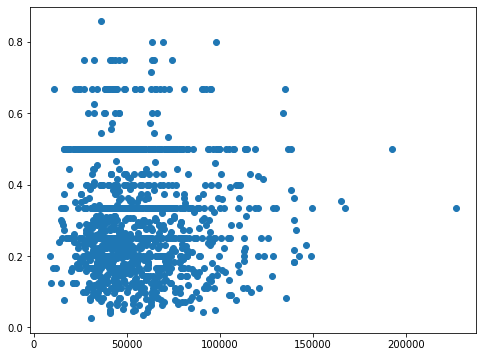

In [194]:
plt.figure(figsize=(8,6))
plt.scatter(household_income,percent_deactivated)

In [193]:
# educational_attainment_for_population_25_and_over= []
# z= None
# for zipcode, percentage in sorted_zipcodes_by_deactivated_percentage:
#     z = search.by_zipcode(zipcode)
    
#     educational_attainment_for_population_25_and_over.append(z.educational_attainment_for_population_25_and_over)


In [ ]:
# school_enrollment_age_3_to_17_and_percent_deactivated = []